<a href="https://colab.research.google.com/github/alexander-toschev/science-reports/blob/main/energy_efficient/BaseModelsComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spikingjelly torch torchvision matplotlib ptflops torchviz torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, ann2snn

from ptflops import get_model_complexity_info

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.15MB/s]


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


def train_cnn(model, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        total_loss = 0
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
        train_losses.append(total_loss / len(train_loader))
        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"[CNN Эпоха {epoch+1}] Потери: {train_losses[-1]:.4f}, Точность: {accuracy:.4f}")
    print("Обучение CNN завершено.")

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), train_losses, label="Loss")
    plt.plot(range(1, epochs + 1), accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Epochs (CNN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def test_cnn(model):
    model.eval()
    total = 0
    correct = 0
    start = time.time()
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    latency = time.time() - start
    acc = correct / total
    print(f"CNN Точность: {acc:.4f}, Латентность: {latency:.2f} сек")
    return acc, 0, latency  # 0 спайков для CNN

In [ ]:
class SimpleANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x):
        return self.net(x)

def train_ann(model, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
        train_losses.append(total_loss / len(train_loader))
        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"[ANN Эпоха {epoch+1}] Потери: {train_losses[-1]:.4f}, Точность: {accuracy:.4f}")
    print("Обучение ANN завершено.")

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), train_losses, label="Loss")
    plt.plot(range(1, epochs + 1), accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Epochs (ANN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test_ann(model):
    model.eval()
    total = 0
    correct = 0
    start = time.time()
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    latency = time.time() - start
    acc = correct / total
    print(f"ANN Accuracy: {acc:.4f}, Latency: {latency:.2f} sec")
    return acc, 0, latency  # 0 spikes for ANN

def convert_ann_to_snn(ann_model):
    converter = ann2snn.Converter(dataloader=train_loader)
    snn_model = converter(ann_model)
    return snn_model

def evaluate_snn(model, T=50):
    model.eval()
    model.to(device)
    total = 0
    correct = 0
    spikes = 0
    losses = []
    accuracies = []
    loss_fn = nn.CrossEntropyLoss()
    start = time.time()
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = torch.zeros(img.size(0), 10, device=device)
            functional.reset_net(model)
            for _ in range(T):
                out += model(img)
            out = torch.clamp(out, min=0)  # Ensure non-negative spike counts
            pred = out.argmax(1)
            loss = loss_fn(out, label)
            losses.append(loss.item())
            correct += (pred == label).sum().item()
            total += label.size(0)
            accuracies.append((pred == label).float().mean().item())
            print(f"[Debug] Batch spikes: {out.sum().item():.2f}")
            spikes += out.sum().item()
    latency = time.time() - start
    acc = correct / total
    print(f"ANN→SNN Accuracy: {acc:.4f}, Spikes: {spikes:.0f}, Latency: {latency:.2f} sec")

    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Loss")
    plt.plot(accuracies, label="Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Batches (ANN→SNN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, spikes, latency

In [ ]:
class SNN_FromScratch(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoding.PoissonEncoder()
        self.fc1 = nn.Linear(28*28, 256)
        self.sn1 = neuron.IFNode(surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(256, 10)
        self.sn2 = neuron.IFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x, T=50):
        x = x.flatten(1)
        out_spike_counter = torch.zeros(x.size(0), 10, device=x.device)
        functional.reset_net(self)
        for _ in range(T):
            encoded = self.encoder(x)
            out = self.fc1(encoded)
            out = self.sn1(out)
            out = self.fc2(out)
            out = self.sn2(out)
            out_spike_counter += out
        return out_spike_counter

def train_snn(model, epochs=5, T=50):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img, T)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
        train_losses.append(total_loss / len(train_loader))
        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"[SNN Эпоха {epoch+1}] Потери: {train_losses[-1]:.4f}, Точность: {accuracy:.4f}")
    print("Обучение SNN завершено.")

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), train_losses, label="Loss")
    plt.plot(range(1, epochs + 1), accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Epochs (SNN from Scratch)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test_snn(model, T=50):
    model.eval()
    total = 0
    correct = 0
    spikes = 0
    losses = []
    accuracies = []
    loss_fn = nn.CrossEntropyLoss()
    start = time.time()
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img, T)
            pred = out.argmax(1)
            loss = loss_fn(out, label)
            losses.append(loss.item())
            correct += (pred == label).sum().item()
            total += label.size(0)
            accuracies.append((pred == label).float().mean().item())
            spikes += out.sum().item()
    latency = time.time() - start
    acc = correct / total
    print(f"SNN Accuracy: {acc:.4f}, Spikes: {spikes:.0f}, Latency: {latency:.2f} sec")

    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Loss")
    plt.plot(accuracies, label="Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Batches (SNN from Scratch)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, spikes, latency

In [ ]:
from spikingjelly.activation_based.neuron import BaseNode

class IzhikevichNeuronLayer(nn.Module):
    def __init__(self, input_size, output_size, a=0.02, b=0.2, c=-65.0, d=8.0):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.v = None
        self.u = None

    def reset_state(self, batch_size, device):
        self.v = torch.full((batch_size, self.fc.out_features), -65.0, device=device)
        self.u = self.b * self.v

    def forward_step(self, x):
        I = self.fc(x) * 100
        dv = 0.04 * self.v ** 2 + 5 * self.v + 140 - self.u + I
        du = self.a * (self.b * self.v - self.u)

        self.v = self.v + dv
        self.u = self.u + du

        spike = torch.relu(self.v - 30.0) / 10.0
        spike = torch.clamp(spike, 0, 1)

        reset_mask = (self.v >= 30.0).float()
        self.v = self.v * (1.0 - reset_mask) + self.c * reset_mask
        self.u = self.u + self.d * reset_mask

        return spike

    def forward(self, x_seq):
        batch_size, time_steps, _ = x_seq.size()
        device = x_seq.device
        self.reset_state(batch_size, device)

        spikes = []
        for t in range(time_steps):
            x_t = x_seq[:, t, :]
            s = self.forward_step(x_t)
            spikes.append(s.unsqueeze(1))

        return torch.cat(spikes, dim=1)

    def reset(self):
        self.v = None
        self.u = None

class IzhikevichSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = IzhikevichNeuronLayer(28*28, 256)
        self.layer2 = IzhikevichNeuronLayer(256, 10)

    def forward(self, x, T=50):
        x = x.flatten(1)  # (B, 784)
        self.reset()
        batch_size = x.size(0)

        self.layer1.reset_state(batch_size, device)
        self.layer2.reset_state(batch_size, device)

        spike_count = torch.zeros(batch_size, 10, device=device)

        for _ in range(T):
            out1 = self.layer1.forward_step(x)
            out2 = self.layer2.forward_step(out1)
            spike_count += out2  # accumulate output spikes

        return spike_count

    def reset(self):
        self.layer1.reset()
        self.layer2.reset()

def train_izh(model, train_loader, epochs=20, T=50):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    accuracies = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img, T)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
        train_losses.append(total_loss / len(train_loader))
        accuracy = correct / total
        accuracies.append(accuracy)
        print(f"[Izhikevich Epoch {epoch+1}] Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")
    print("Training of Izhikevich model completed.")

    # Построение графиков
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, epochs + 1), train_losses, label="Loss")
    plt.plot(range(1, epochs + 1), accuracies, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Epochs (Izhikevich SNN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test_izh(model, test_loader, T=50):
    model.eval()
    total = 0
    correct = 0
    spikes = 0
    losses = []
    accuracies = []
    loss_fn = nn.CrossEntropyLoss()
    start = time.time()
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img, T)
            pred = out.argmax(1)
            loss = loss_fn(out, label)
            losses.append(loss.item())
            correct += (pred == label).sum().item()
            total += label.size(0)
            accuracies.append((pred == label).float().mean().item())
            spikes += out.sum().item()
    latency = time.time() - start
    acc = correct / total
    print(f"Izhikevich SNN Accuracy: {acc:.4f}, Spikes: {spikes:.0f}, Latency: {latency:.2f} sec")

    plt.figure(figsize=(8, 4))
    plt.plot(losses, label="Loss")
    plt.plot(accuracies, label="Accuracy")
    plt.xlabel("Batch")
    plt.ylabel("Value")
    plt.title("Loss and Accuracy over Batches (Izhikevich SNN)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, spikes, latency

In [ ]:
# === Визуализация активности нейронов Ижикевича ===
def visualize_izh_spike_activity(model, T=50):
    model.eval()
    with torch.no_grad():
        for img, _ in test_loader:
            img = img.to(device)
            x = img.flatten(1)
            batch_size = x.size(0)
            # переменная device уже определена глобально, повторное определение не требуется

            model.layer1.reset_state(batch_size, device)
            model.layer2.reset_state(batch_size, device)

            spikes1 = []
            spikes2 = []
            for _ in range(T):
                out1 = model.layer1.forward_step(x)
                out2 = model.layer2.forward_step(out1)
                spikes1.append(out1.unsqueeze(1).cpu())
                spikes2.append(out2.unsqueeze(1).cpu())

            spikes1 = torch.cat(spikes1, dim=1).numpy()
            spikes2 = torch.cat(spikes2, dim=1).numpy()

            mean_spikes1 = spikes1.mean(axis=0)
            mean_spikes2 = spikes2.mean(axis=0)

            plt.figure(figsize=(10, 4))
            plt.imshow(mean_spikes1.T, aspect='auto', cmap='hot')
            plt.colorbar()
            plt.title("Neuron Activity Layer 1 (256) Over Time")
            plt.xlabel("Time (t)")
            plt.ylabel("Neurons")
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(8, 3))
            plt.imshow(mean_spikes2.T, aspect='auto', cmap='hot')
            plt.colorbar()
            plt.title("Neuron Activity Layer 2 (10 Classes) Over Time")
            plt.xlabel("Time (t)")
            plt.ylabel("Class")
            plt.tight_layout()
            plt.show()
            break  # только один батч

In [ ]:
# === Визуализация расширенных метрик ===
def compare_and_plot(ann_metrics, ann2snn_metrics, snn_metrics, izh_metrics, cnn_metrics, cnn_flops):
    df = pd.DataFrame({
        "Model": ["ANN", "ANN→SNN", "SNN from scratch", "Izhikevich SNN", "CNN"],
        "Accuracy (%)": [
            ann_metrics[0]*100,
            ann2snn_metrics[0]*100,
            snn_metrics[0]*100,
            izh_metrics[0]*100,
            cnn_metrics[0]*100
        ],
        "Total Spikes": [
            0,
            ann2snn_metrics[1],
            snn_metrics[1],
            izh_metrics[1],
            cnn_metrics[1]
        ],
        "Latency (s)": [
            ann_metrics[2],
            ann2snn_metrics[2],
            snn_metrics[2],
            izh_metrics[2],
            cnn_metrics[2]
        ],
        "Energy (Million spikes)": [
            0,
            ann2snn_metrics[1] / 1e6,
            snn_metrics[1] / 1e6,
            izh_metrics[1] / 1e6,
            0
        ],
        "Spikes per sample": [
            0,
            ann2snn_metrics[1] / len(test_loader.dataset),
            snn_metrics[1] / len(test_loader.dataset),
            izh_metrics[1] / len(test_loader.dataset),
            0
        ],
        "FLOPs (M)": [
            ann_flops,
            ann2snn_flops,
            snn_flops,
            izh_flops,
            cnn_flops
        ],
        "Energy (pJ) - from Spikes": [
            0,
            ann2snn_metrics[1] * 0.9,
            snn_metrics[1] * 0.9,
            izh_metrics[1] * 0.9,
            0
        ],
        "Energy (pJ) - from FLOPs": [
            ann_flops * 1e6 * 4.6,
            ann2snn_flops * 1e6 * 4.6,
            snn_flops * 1e6 * 4.6,
            izh_flops * 1e6 * 4.6,
            cnn_flops * 1e6 * 4.6
        ]
    })

    df["Total Energy (pJ)"] = df["Energy (pJ) - from Spikes"] + df["Energy (pJ) - from FLOPs"]
    df["Efficiency (Acc / Energy ×1e9)"] = df["Accuracy (%)"] * 1e9 / df["Total Energy (pJ)"]

    sns.set(style="whitegrid", font_scale=1.2)

    def plot_metric(title, y_label):
        plt.figure(figsize=(6, 4))
        sns.barplot(data=df, x="Model", y=y_label, color="steelblue")
        plt.title(title)
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.show()

    plot_metric("Accuracy Comparison", "Accuracy (%)")
    plot_metric("Total Spikes", "Total Spikes")
    plot_metric("Spikes per Sample", "Spikes per sample")
    plot_metric("Latency Comparison", "Latency (s)")
    plot_metric("FLOPs (Million)", "FLOPs (M)")
    plot_metric("Energy Estimate (Million spikes)", "Energy (Million spikes)")
    plot_metric("Energy Estimate (pJ) from Spikes", "Energy (pJ) - from Spikes")
    plot_metric("Energy Estimate (pJ) from FLOPs", "Energy (pJ) - from FLOPs")
    plot_metric("Total Energy Estimate (pJ)", "Total Energy (pJ)")
    plot_metric("Efficiency (Acc / Energy ×1e9)", "Efficiency (Acc / Energy ×1e9)")

    # === Stacked bar chart для суммарной энергии ===
    df_energy = df[["Model", "Energy (pJ) - from Spikes", "Energy (pJ) - from FLOPs"]].copy()
    df_energy.set_index("Model", inplace=True)
    df_energy.plot(kind="bar", stacked=True, figsize=(8, 5), color=["#1f77b4", "#ff7f0e"])
    plt.ylabel("Energy (pJ)")
    plt.title("Total Energy Estimate (pJ) - Stacked")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

In [ ]:
# === Получение FLOPs моделей ===
def get_flops(model, input_size):
    model.eval()

    def prepare_input(res):
        return {'x': torch.randn(1, *res).to(next(model.parameters()).device)}

    try:
        macs, params = get_model_complexity_info(
            model,
            input_res=input_size,
            input_constructor=prepare_input,
            as_strings=False,
            print_per_layer_stat=False
        )
        if macs is None:
            print("[Warning] MACs returned None. Model may be unsupported.")
            return 0
        flops = 2 * macs  # FLOPs ≈ 2 * MACs
        return flops / 1e6  # в миллионах FLOPs
    except Exception as e:
        print(f"[Error] Unable to compute FLOPs: {e}")
        return 0

In [ ]:
from torchsummary import summary

# === Графическая визуализация вычислительных графов моделей ===
from torchviz import make_dot

def visualize_model_graph(model, input_shape, model_name):
    dummy_input = torch.randn(1, *input_shape).to(device)
    model.to(device)
    model.eval()
    output = model(dummy_input)
    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.format = "png"
    dot.render(f"graph_{model_name}", cleanup=True)
    print(f"Граф модели '{model_name}' сохранён как graph_{model_name}.png")

In [ ]:
# === Функция измерения времени ===
def measure_inference_time(model, input_tensor, repetitions=100):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        _ = model(input_tensor)

    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()

    with torch.no_grad():
        for _ in range(repetitions):
            _ = model(input_tensor)

    if device.type == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()

    avg_time_sec = (end_time - start_time) / repetitions
    avg_time_ms = avg_time_sec * 1000

    print(f"Average inference time per image: {avg_time_ms:.4f} ms")

    return avg_time_ms

In [ ]:
# === Функция подсчета среднего количества спайков ===
def measure_average_spikes(model, input_tensor, T=30):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        output = model(input_tensor)
    if isinstance(output, tuple):
        spikes = output[0]
    else:
        spikes = output
    spikes = torch.clamp(spikes, min=0)
    return spikes.sum().item() / input_tensor.size(0)

In [ ]:
# === Визуализация архитектур моделей ===
print("=== Архитектура ANN ===")
ann_model = SimpleANN()
ann_model.to(device)
summary(ann_model, (1, 28, 28))

print("=== Архитектура SNN ===")
snn_model = SNN_FromScratch()
snn_model.to(device)
summary(snn_model, (1, 28, 28))

print("=== Архитектура Izhikevich ===")
izh_model = IzhikevichSNN()
izh_model.to(device)
summary(izh_model, (1, 28, 28))

print("=== Архитектура CNN ===")
cnn_model = SimpleCNN()
cnn_model.to(device)
summary(cnn_model, (1, 28, 28))

visualize_model_graph(ann_model, (1, 28, 28), "ann")
visualize_model_graph(snn_model, (1, 28, 28), "snn")
# visualize_model_graph(izh_model, (1, 28, 28), "izhikevich")
visualize_model_graph(cnn_model, (1, 28, 28), "cnn")

=== Архитектура ANN ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.79
----------------------------------------------------------------
=== Архитектура SNN ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    PoissonEncoder-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         2

[ANN Эпоха 1] Потери: 0.2263, Точность: 0.9324
[ANN Эпоха 2] Потери: 0.0930, Точность: 0.9719
[ANN Эпоха 3] Потери: 0.0650, Точность: 0.9799
[ANN Эпоха 4] Потери: 0.0468, Точность: 0.9849
[ANN Эпоха 5] Потери: 0.0363, Точность: 0.9885
Обучение ANN завершено.


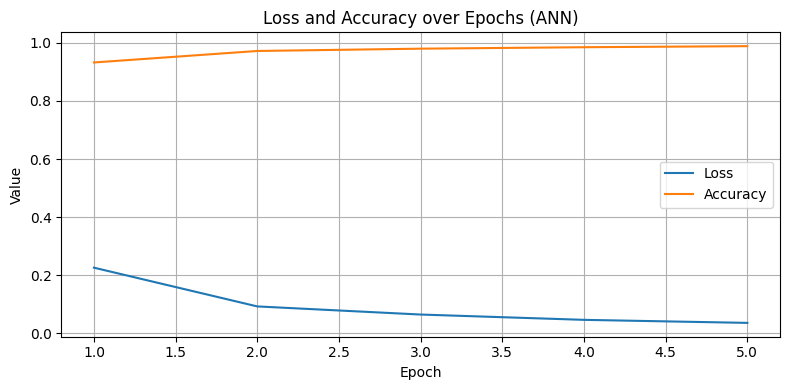

ANN Accuracy: 0.9791, Latency: 1.84 sec


100%|██████████| 938/938 [00:12<00:00, 77.32it/s]


[Debug] Batch spikes: 44728.95
[Debug] Batch spikes: 43986.50
[Debug] Batch spikes: 46435.60
[Debug] Batch spikes: 43865.31
[Debug] Batch spikes: 45772.81
[Debug] Batch spikes: 43827.52
[Debug] Batch spikes: 42427.62
[Debug] Batch spikes: 48061.45
[Debug] Batch spikes: 43833.29
[Debug] Batch spikes: 45219.11
[Debug] Batch spikes: 42606.27
[Debug] Batch spikes: 47386.88
[Debug] Batch spikes: 45430.00
[Debug] Batch spikes: 44927.50
[Debug] Batch spikes: 44216.88
[Debug] Batch spikes: 45337.45
[Debug] Batch spikes: 46677.88
[Debug] Batch spikes: 46542.56
[Debug] Batch spikes: 45055.02
[Debug] Batch spikes: 39961.75
[Debug] Batch spikes: 42801.83
[Debug] Batch spikes: 43010.97
[Debug] Batch spikes: 42566.69
[Debug] Batch spikes: 42837.15
[Debug] Batch spikes: 42819.91
[Debug] Batch spikes: 45284.16
[Debug] Batch spikes: 44137.38
[Debug] Batch spikes: 41155.64
[Debug] Batch spikes: 44357.75
[Debug] Batch spikes: 42981.43
[Debug] Batch spikes: 43248.11
[Debug] Batch spikes: 42558.85
[Debug] 

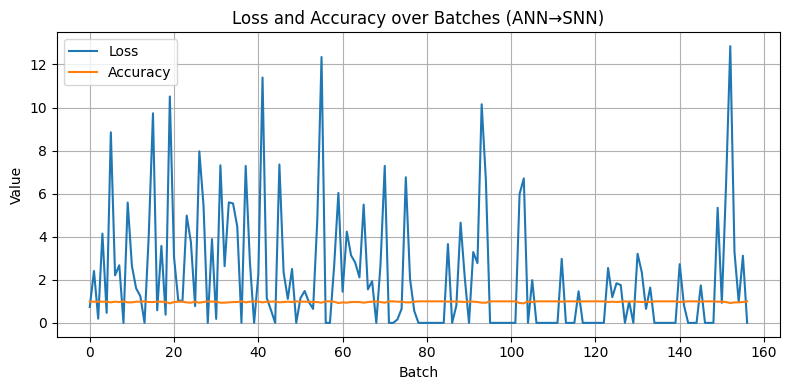

[SNN Эпоха 1] Потери: 0.4720, Точность: 0.8647
[SNN Эпоха 2] Потери: 0.2122, Точность: 0.9416
[SNN Эпоха 3] Потери: 0.1541, Точность: 0.9567
[SNN Эпоха 4] Потери: 0.1309, Точность: 0.9632
[SNN Эпоха 5] Потери: 0.1170, Точность: 0.9706
Обучение SNN завершено.


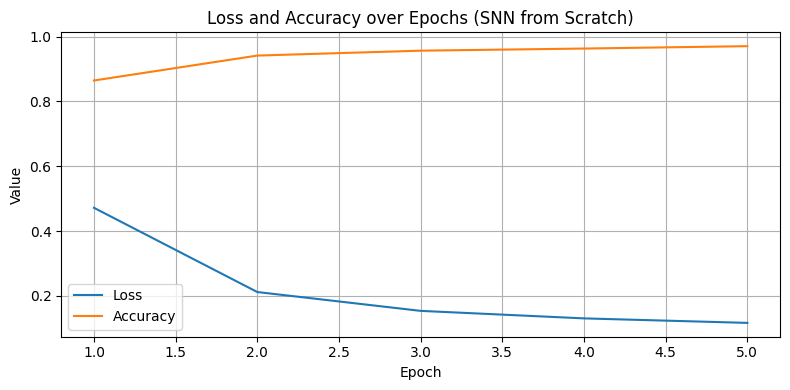

SNN Accuracy: 0.9625, Spikes: 1111375, Latency: 5.23 sec


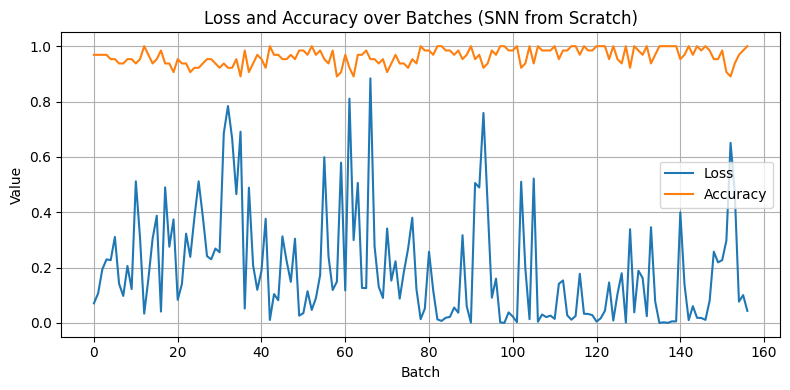

[Izhikevich Epoch 1] Loss: 1.8627, Accuracy: 0.4074
[Izhikevich Epoch 2] Loss: 1.1982, Accuracy: 0.6350
[Izhikevich Epoch 3] Loss: 1.1184, Accuracy: 0.6551
[Izhikevich Epoch 4] Loss: 1.0528, Accuracy: 0.6852
[Izhikevich Epoch 5] Loss: 1.1206, Accuracy: 0.6553
Training of Izhikevich model completed.


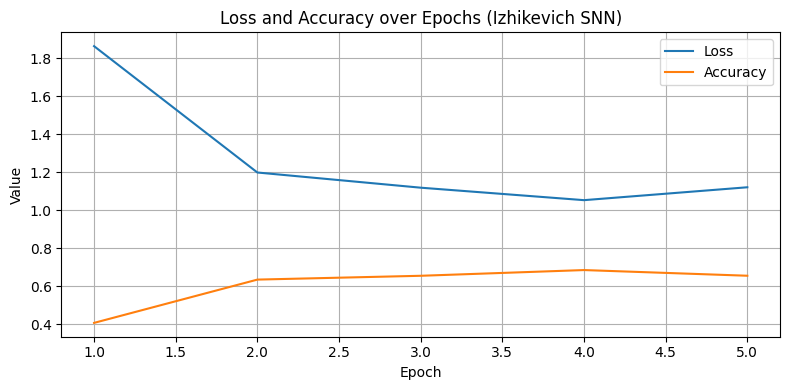

Izhikevich SNN Accuracy: 0.5425, Spikes: 2204315, Latency: 8.76 sec


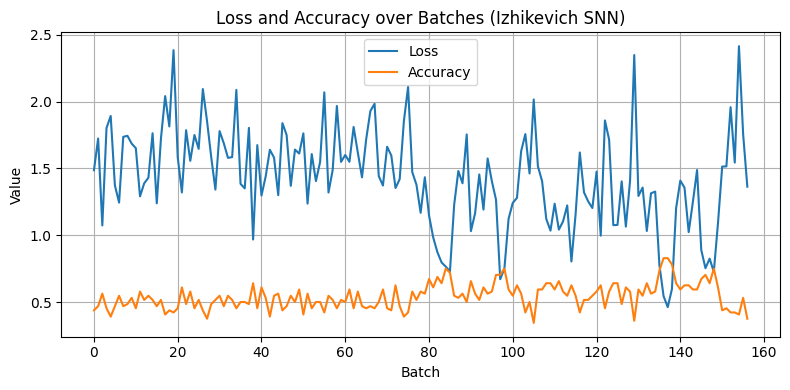

[CNN Эпоха 1] Потери: 0.1332, Точность: 0.9588
[CNN Эпоха 2] Потери: 0.0420, Точность: 0.9864
[CNN Эпоха 3] Потери: 0.0280, Точность: 0.9911
[CNN Эпоха 4] Потери: 0.0217, Точность: 0.9926
[CNN Эпоха 5] Потери: 0.0150, Точность: 0.9950
Обучение CNN завершено.


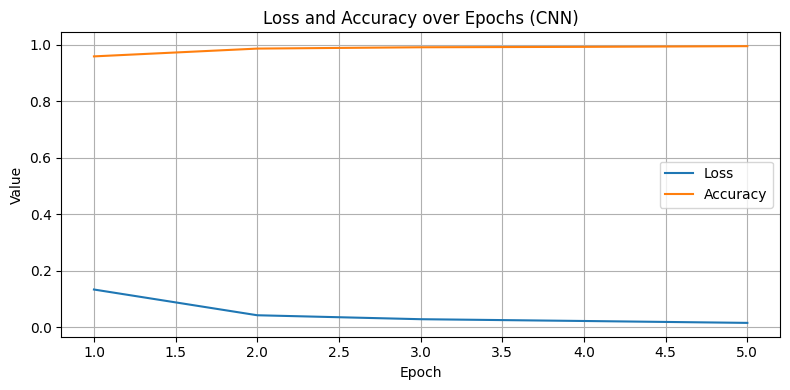

CNN Точность: 0.9889, Латентность: 2.08 сек


In [ ]:
# === Запуск всех моделей ===
ann_model = SimpleANN()
train_ann(ann_model)
ann_metrics = test_ann(ann_model)
snn_converted = convert_ann_to_snn(ann_model)
ann2snn_metrics = evaluate_snn(snn_converted)

snn_model = SNN_FromScratch()
train_snn(snn_model)
snn_metrics = test_snn(snn_model)

izh_model = IzhikevichSNN()
train_izh(izh_model, train_loader, epochs=5, T=25)
izh_metrics = test_izh(izh_model, test_loader)

cnn_model = SimpleCNN()
train_cnn(cnn_model)
cnn_metrics = test_cnn(cnn_model)

Average inference time per image: 0.0954 ms
Average inference time per image: 0.2495 ms
Average inference time per image: 55.0090 ms
Average inference time per image: 58.8291 ms
Average inference time per image: 0.3080 ms
                Model  Accuracy (%)  Inference Time (ms)  Average Spikes  \
0                 ANN         97.91             0.095358             784   
1          ANN -> SNN         97.97             0.249529             165   
2  SNN (from scratch)         96.25            55.009003             112   
3          Izhikevich         54.25            58.829134             153   
4                 CNN         98.89             0.308046             784   

   Relative Energy  
0         1.000000  
1         0.210459  
2         0.142857  
3         0.195153  
4         1.000000  


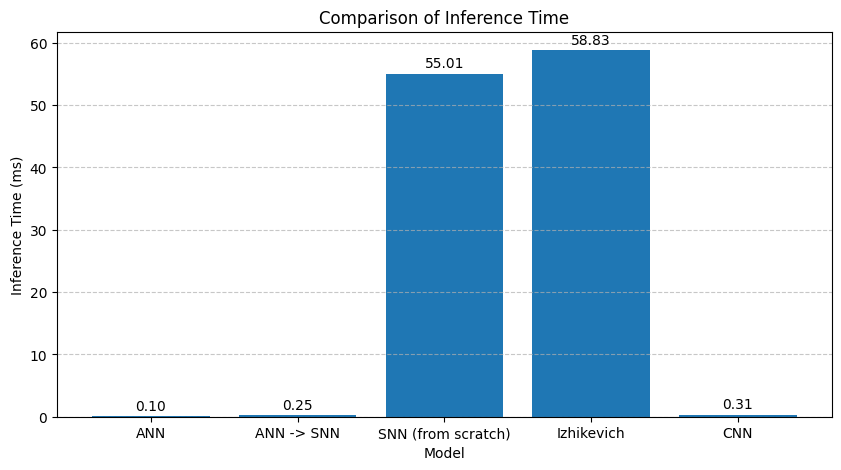

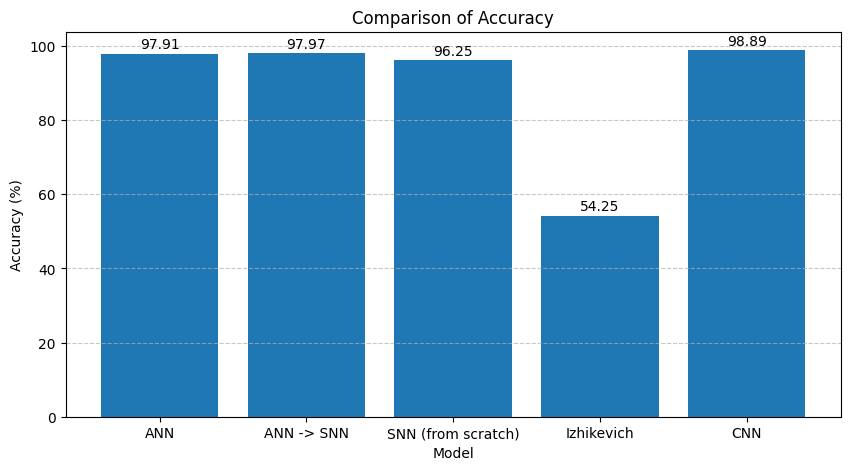

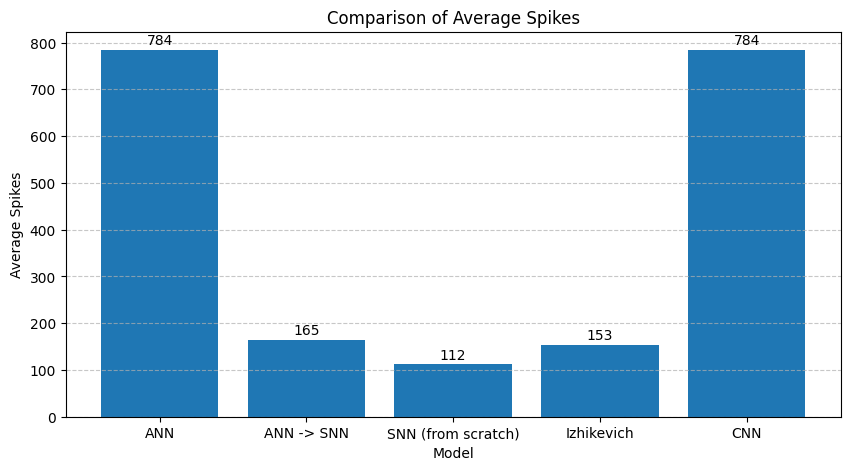

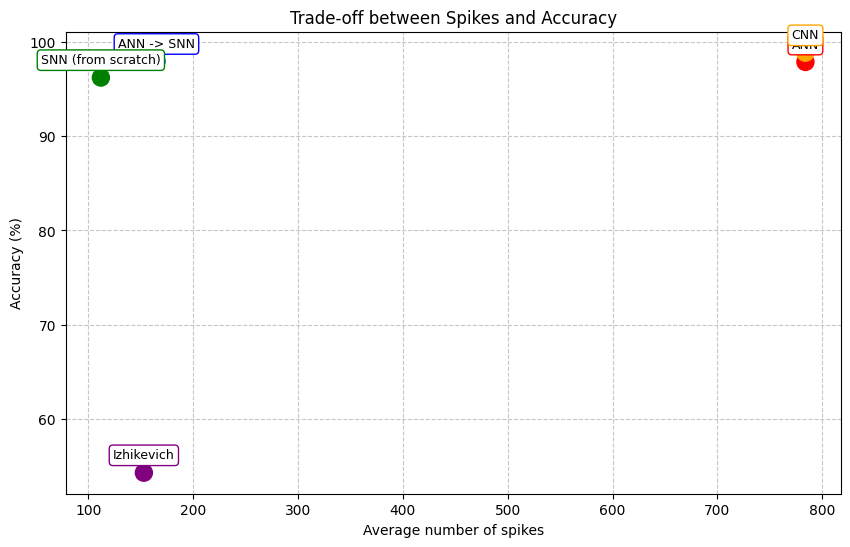

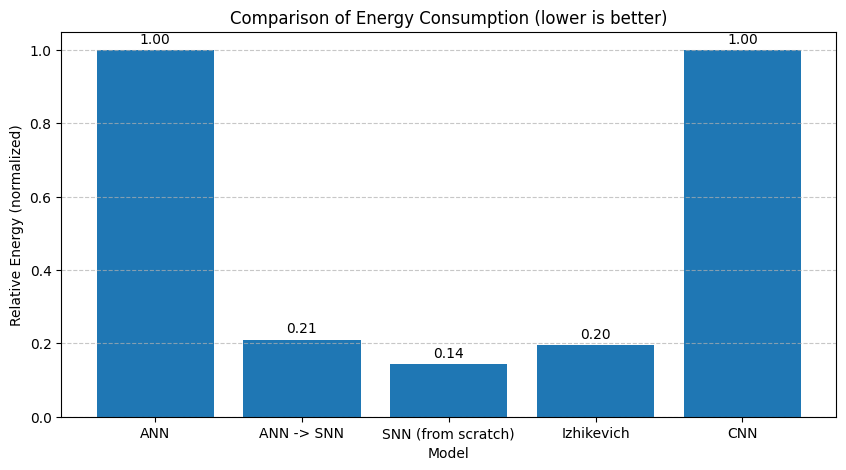

In [ ]:
# === Замеры времени и спайков ===

dummy_input = torch.randn(1, 1, 28, 28).to(device)

# ANN
time_ann = measure_inference_time(ann_model, dummy_input)
spikes_ann = 784  # Dense расчет: каждый вход влияет на каждый выход

# ANN -> SNN
time_ann2snn = measure_inference_time(snn_converted, dummy_input)
spikes_ann2snn = measure_average_spikes(snn_converted, dummy_input)

# SNN (from scratch)
time_snn = measure_inference_time(snn_model, dummy_input)
spikes_snn = measure_average_spikes(snn_model, dummy_input)

# Izhikevich
time_izhikevich = measure_inference_time(izh_model, dummy_input)
spikes_izhikevich = measure_average_spikes(izh_model, dummy_input)

# CNN
time_cnn = measure_inference_time(cnn_model, dummy_input)
spikes_cnn = 784  # Примем аналогично dense-связям

# === Формируем таблицу результатов ===
results_df = pd.DataFrame({
    'Model': ['ANN', 'ANN -> SNN', 'SNN (from scratch)', 'Izhikevich', 'CNN'],
    'Accuracy (%)': [ann_metrics[0] * 100, ann2snn_metrics[0] * 100, snn_metrics[0] * 100, izh_metrics[0] * 100, cnn_metrics[0] * 100],
    'Inference Time (ms)': [time_ann, time_ann2snn, time_snn, time_izhikevich, time_cnn],
    'Average Spikes': [round(spikes_ann), round(spikes_ann2snn), round(spikes_snn), round(spikes_izhikevich), round(spikes_cnn)]
})

# === Calculate Relative Energy ===
full_dense_ops = 784  # 28x28 input size
results_df['Relative Energy'] = [
    1.0,  # ANN
    results_df['Average Spikes'][1] / full_dense_ops,
    results_df['Average Spikes'][2] / full_dense_ops,
    results_df['Average Spikes'][3] / full_dense_ops,
    1.0   # CNN
]

print(results_df)

# === Строим графики ===

# Время вывода
plt.figure(figsize=(10, 5))
bars = plt.bar(results_df['Model'], results_df['Inference Time (ms)'])
plt.xlabel('Model')
plt.ylabel('Inference Time (ms)')
plt.title('Comparison of Inference Time')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}', ha='center', va='bottom')
plt.show()

# Точность моделей
plt.figure(figsize=(10, 5))
bars = plt.bar(results_df['Model'], results_df['Accuracy (%)'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Accuracy')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.2f}', ha='center', va='bottom')
plt.show()

# Среднее число спайков
plt.figure(figsize=(10, 5))
bars = plt.bar(results_df['Model'], results_df['Average Spikes'])
plt.xlabel('Model')
plt.ylabel('Average Spikes')
plt.title('Comparison of Average Spikes')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height:.0f}', ha='center', va='bottom')
plt.show()

# === Строим график компромисса точность vs число спайков ===
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange']
sizes = [150, 150, 150, 150, 150]

plt.scatter(results_df['Average Spikes'], results_df['Accuracy (%)'], s=sizes, c=colors)

for i in range(len(results_df)):
    plt.annotate(
        results_df['Model'][i],
        (results_df['Average Spikes'][i], results_df['Accuracy (%)'][i]),
        textcoords="offset points",
        xytext=(0,10),
        ha='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[i], facecolor='white')
    )

plt.xlabel('Average number of spikes')
plt.ylabel('Accuracy (%)')
plt.title('Trade-off between Spikes and Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Relative Energy Comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(results_df['Model'], results_df['Relative Energy'])
plt.xlabel('Model')
plt.ylabel('Relative Energy (normalized)')
plt.title('Comparison of Energy Consumption (lower is better)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')
plt.show()